In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from pickle import dump,load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, log_loss, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from keras.utils import to_categorical
import os
%matplotlib inline

In [2]:
# import CSV file save in EDA
drugs_model = pd.read_csv('drugs_model.csv')

In [7]:
# create Features and labels 
sentences =drugs_model['clean_text'].values.astype('U').reshape(-1,1)
sentences = [str(x) for x in sentences]
y=drugs_model['rating_class_numeric'].values.reshape(-1,1)

In [4]:
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(return_indices=True)
# X_rus, y_rus, id_rus = rus.fit_sample(sentences, y)

In [8]:
# Convert Y into categorical
y = to_categorical(y)

In [9]:
y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [10]:
# Tokenize using Keras. Use top 10000 words and convert into sentences
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [11]:
# Vocabulary size and account for one additional or unknown word
vocabulary_size = len(tokenizer.word_counts)+1

In [18]:
# check the unique word count
print('Found %d unique words.' % vocabulary_size)

Found 60366 unique words.


In [13]:
# split features and labels
sentences_train, sentences_test, y_train, y_test = train_test_split(sequences, y, test_size=0.25, random_state=42)

In [19]:
# pad sequences maximum len to be 100. This will add zeros after the word vectors
max_length = 100

sentences_train = pad_sequences(sentences_train, padding='post', maxlen=max_length)
sentences_test = pad_sequences(sentences_test, padding='post', maxlen=max_length)

print(sentences_train[0, :])

print(y_train.shape)

[  27   36   10    7 1134   11 1052   14   17    3   43 1430  139    1
   11  206   19   38   16   87  190    1  219   99 1108   15 9704  497
 1082    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
(161297, 3)


In [0]:
# class_weights = class_weight.compute_class_weight('balanced'
#                                                ,np.unique(y_train)
#                                                ,y_train)

# class_weight_dict = dict(enumerate(class_weights))

In [0]:
# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTEENN

# method = SMOTE()

# # Create the resampled feature set
# X_rus, y_rus = method.fit_sample(sentences_train, y_train)

In [20]:
# training validation and loss
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [21]:
# build model layers. 
embedding_dim = 100

max_length = 100
model = Sequential()
model.add(layers.Embedding(vocabulary_size+1, embedding_dim, input_length=max_length))
model.add(Dropout(0.2))
model.add(layers.Conv1D(filters = 128, kernel_size=5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          6036700   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 33        
Total params: 6,102,151
Trainable params: 6,102,151
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model. 

history = model.fit(sentences_train, y_train,class_weight = {0: 2.,1: 4.,2: .6},
                    epochs=20,
                    verbose=1,
                    validation_data=(sentences_train, y_train),
                    batch_size=1024, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001), 
                                ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto') ])
loss, accuracy = model.evaluate(sentences_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(sentences_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Train on 161297 samples, validate on 161297 samples
Epoch 1/20
 37888/161297 [======>.......................] - ETA: 1:43 - loss: 1.3564 - acc: 0.2472

In [ ]:
# load the saved model. 

model = load_model('keras_model')

In [ ]:
# calculate probabilities
preds = to_categorical(model.predict_classes(sentences_test))

In [25]:
# print metrics
print(confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1)))

print('\n', 'Classification Report')
print(classification_report(y_test, preds))


print('\n', 'accuracy Score')
print('Accuracy: ', accuracy_score(y_test, preds))

print('\n', 'f1 Score')
print(metrics.f1_score(y_test, preds, average='weighted'))


[[11732   458  1161]
 [  663  3284   963]
 [ 1290   768 33447]]

 Classification Report
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     13351
           1       0.73      0.67      0.70      4910
           2       0.94      0.94      0.94     35505

   micro avg       0.90      0.90      0.90     53766
   macro avg       0.84      0.83      0.84     53766
weighted avg       0.90      0.90      0.90     53766
 samples avg       0.90      0.90      0.90     53766


 accuracy Score
Accuracy:  0.9013688948406056

 f1 Score
0.9006891662727309


''

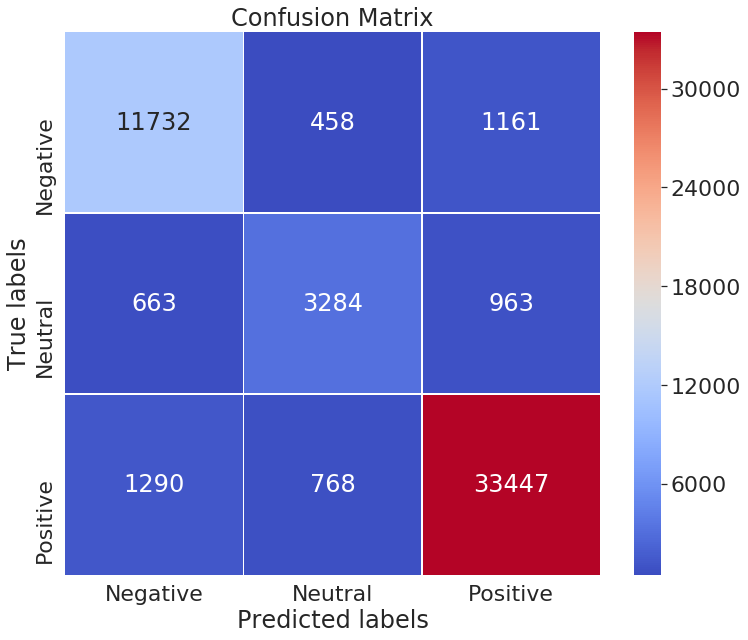

In [26]:
# plot ROC curve
sns.set(rc={'figure.figsize':(12,10)}, font_scale=2)
ax= plt.subplot()
cm = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
sns.heatmap(cm, annot=True, ax = ax, fmt='g', linewidths=.5, cmap='coolwarm'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative',  'Neutral', 'Positive']); 
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
plt.savefig('Confusion matrix CNN')
;

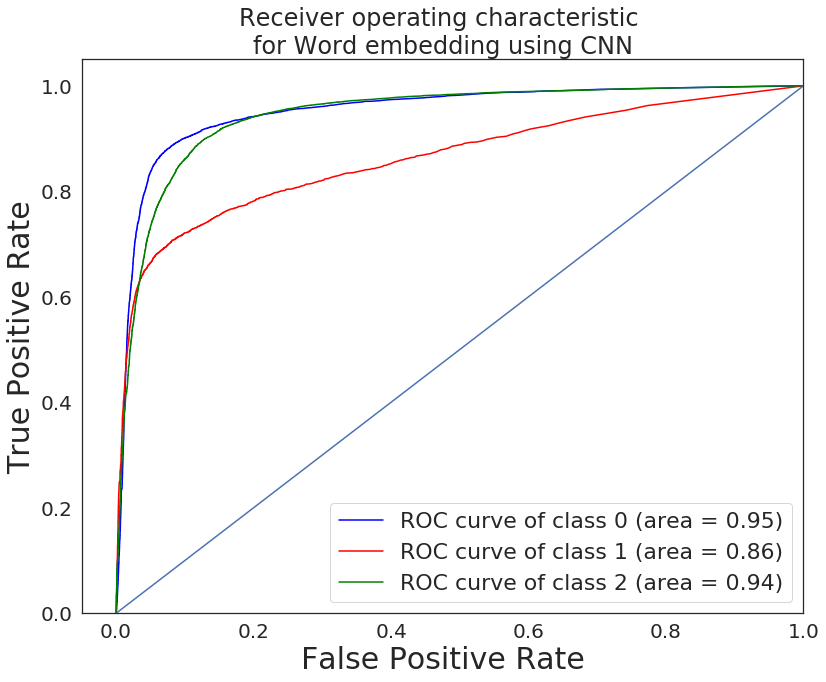

In [27]:
sns.set(rc={'figure.figsize':(12,10)}, font_scale=2)
sns.set_style("white")
preds = model.predict(sentences_test)
 

n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1])
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 30)
plt.ylabel('True Positive Rate',fontsize = 30)
plt.title('Receiver operating characteristic \nfor Word embedding using CNN')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('ROC weight loss.png')
plt.savefig('ROC CNN')
plt.show(); 